Process for CVQC

In [1]:
import csv
import time
import random
import numpy as np
import strawberryfields as sf
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from strawberryfields import ops
from itertools import combinations
from strawberryfields.apps import data, qchem, plot
from strawberryfields.utils import random_interferometer

Step1: Mapping

In [2]:
# function that take a raw matrix and k (number of columns) and n (the nth number you want to compare) value in, return the best k columns
def find_best_k_combination(matrix, k, n):
    # get all possible combination
    num_columns = matrix.shape[1]
    column_combinations = combinations(range(num_columns), k)
        
#     column_combinations = get_column_combinations(matrix, k)
    
    strength = []
    Combination = []

    for combination in column_combinations:
        Combination.append(combination)
        selected_columns = matrix[:, combination]
        # calculate the row abs square sum
        row_sums = np.sum(np.abs(selected_columns) ** 2, axis=1)
        # make it decrease
        sorted_indices = np.argsort(row_sums)[::-1]
        sorted_row_sums = row_sums[sorted_indices]
        val = sorted_row_sums[n-1]
        strength.append(val)

    largest_value = np.max(strength)
    largest_index = np.argmax(strength)

    # find the best combination
    best_combination = Combination[largest_index]
    best_selected_columns = matrix[:, best_combination]

    return best_selected_columns

In [3]:
def mapping_for_U2_row(U, len_list):
    
    M, N = U.shape
    U_per = U
    
    # calculate the sum of first len for U_per
    selected_columns = U_per[:, :len_list[0]] 
    # calculate the row abs square sum
    row_sums = np.sum(np.abs(selected_columns) ** 2, axis=1)
    
    # decide the row rotation
    sorted_indices = np.argsort(row_sums)
    U_per_new = U_per[sorted_indices]
    
    # Find row permutation
    row_permutation = []
    for row in range(U_per_new.shape[0]):
        for i in range(U_per.shape[0]):
            if np.array_equal(U_per_new[row, :], U_per[i, :]):
                row_permutation.append(i)
                break
                
    # find the rows permutation matrix
    row_per_matrix = np.zeros((M, M))
    for i in range(M):
        row_per_matrix[i, row_permutation[i]] = 1
        
    
    U_final = U_per_new
    
    # U_final = U_per, out put U_final and the permutation
    return U_final, row_per_matrix.T

In [4]:
# final function, recieve the original matrix and a list of len, also n (the nth number you want to compare), return the permuted matrix
# U = row_per_matrix*U'*col_per_matrix
def mapping(U, len_list, n):
    
    M, N = U.shape
    total_len = sum(len_list)
    assert N == total_len
    
    # copy U
    U_t = U

    for i, length in enumerate(len_list):
        U_new = find_best_k_combination(U_t, length, n)
        
        # Find column indices in the larger matrix corresponding to the smaller matrix
        selected_columns = []
        for col in range(U_new.shape[1]):
            for j in range(U_t.shape[1]):
                if np.array_equal(U_new[:, col], U_t[:, j]):
                    selected_columns.append(j)
                    break

        # drop U_new from U_t
        U_t = np.delete(U_t, selected_columns, axis=1)
        
        # add U_new to U_per
        if i==0:
            U_per = U_new
        else:
            U_per = np.hstack((U_per, U_new))
      
      
    # find the permutation from U_per to U
    col_permutation = []
    for col in range(U_per.shape[1]):
        for i in range(U.shape[1]):
            if np.array_equal(U_per[:, col], U[:, i]):
                col_permutation.append(i)
                break
                
    # find the columns permutation matrix
    col_per_matrix = np.zeros((N, N))
    for i in range(N):
        col_per_matrix[col_permutation[i], i] = 1
        


    # calculate the sum of first len for U_per
    selected_columns = U_per[:, :len_list[0]] 
    # calculate the row abs square sum
    row_sums = np.sum(np.abs(selected_columns) ** 2, axis=1)
    
    # decide the row rotation
    sorted_indices = np.argsort(row_sums)
    U_per_new = U_per[sorted_indices]
    
    # Find row permutation
    row_permutation = []
    for row in range(U_per_new.shape[0]):
        for i in range(U_per.shape[0]):
            if np.array_equal(U_per_new[row, :], U_per[i, :]):
                row_permutation.append(i)
                break
                
    # find the rows permutation matrix
    row_per_matrix = np.zeros((M, M))
    for i in range(M):
        row_per_matrix[i, row_permutation[i]] = 1
        
    
    U_final = U_per_new
    
    # U_final = U_per, out put U_final and the permutation
    return U_final, col_per_matrix.T, row_per_matrix.T

Step2: Matrix Decomposition

In [5]:
# Define the left eliminate equations
def left_equations(variables,parameters):
    theta, phi = variables
    a_r, a_i, b_r, b_i = parameters
    eq1 = a_r * np.cos(phi) * np.cos(theta) + a_i * np.sin(phi) * np.cos(theta) - b_r * np.sin(theta)
    eq2 = a_i * np.cos(phi) * np.cos(theta) - a_r * np.sin(phi) * np.cos(theta) - b_i * np.sin(theta)
    return [eq1, eq2]

# function of left elimination
def left_elimination(a,b):
    a_r = np.real(a)
    a_i = np.imag(a)
    b_r = np.real(b)
    b_i = np.imag(b)
    
    # Solve the system of equations
    initial_guess = [0, 0]  # Initial guess for the variables
    parameters = [a_r, a_i, b_r, b_i]
    raw_solution = fsolve(left_equations, initial_guess, args=(parameters,))
    
    
    if np.abs(a_r) < 1e-8 and np.abs(b_i) < 1e-8:
            raw_solution = [np.arctan(a_i/b_r), np.pi/2]
        
    if np.abs(a_i) < 1e-8 and np.abs(b_r) < 1e-8:
            raw_solution = [np.arctan(-a_r/b_i), np.pi/2]
            
            
    if np.abs(b_r) < 1e-8 and np.abs(b_i) < 1e-8:
            raw_solution = [np.pi/2, 0]
    
    
    normalized_solution = [angle % (2 * np.pi) for angle in raw_solution]
    solution = []
    for angle in normalized_solution:
        if angle < np.pi:
            solution.append(angle)
        else:
            solution.append(angle-2*np.pi)

    # Print the solution
#     print("Solution:", solution)
    return solution

In [6]:
# Define the right eliminate equations
def right_equations(variables,parameters):
    theta, phi = variables
    a_r, a_i, b_r, b_i = parameters
    eq1 = a_r * np.cos(phi) * np.sin(theta) + a_i * np.sin(phi) * np.sin(theta) + b_r * np.cos(theta)
    eq2 = a_i * np.cos(phi) * np.sin(theta) - a_r * np.sin(phi) * np.sin(theta) + b_i * np.cos(theta)
    return [eq1, eq2]

# function of right elimination
def right_elimination(a,b):
    a_r = np.real(a)
    a_i = np.imag(a)
    b_r = np.real(b)
    b_i = np.imag(b)
    
    # Solve the system of equations
    initial_guess = [0, 0]  # Initial guess for the variables
    parameters = [a_r, a_i, b_r, b_i]
    raw_solution = fsolve(right_equations, initial_guess, args=(parameters,))
    
    if np.abs(a_r) < 1e-8 and np.abs(b_i) < 1e-8:
        raw_solution = [np.arctan(-b_r/a_i), np.pi/2]
        
    if np.abs(a_i) < 1e-8 and np.abs(b_r) < 1e-8:
        raw_solution = [np.arctan(b_i/a_r), np.pi/2]
        
    if np.abs(a_r) < 1e-8 and np.abs(a_i) < 1e-8:
        raw_solution = [np.pi/2, 0]
    
    normalized_solution = [angle % (2 * np.pi) for angle in raw_solution]
    solution = []
    for angle in normalized_solution:
        if angle < np.pi:
            solution.append(angle)
        else:
            solution.append(angle-2*np.pi)

    # Print the solution
#     print("Solution:", solution)
    return solution

In [7]:
# give rotation matrix with idx_1 < idx_2
def rotation(theta, phi, n, idx_1, idx_2):
    I = np.eye(n, dtype=complex)
    I[idx_1,idx_1] = np.cos(theta)*(np.cos(phi)-np.sin(phi)*1j)
    I[idx_1,idx_2] = np.sin(theta)*(np.cos(phi)-np.sin(phi)*1j)
    I[idx_2,idx_1] = -np.sin(theta)
    I[idx_2,idx_2] = np.cos(theta)
    
    return I

In [8]:
# matrix permutation
def permutation(U):
    
    rows, columns = U.shape
    assert(rows==columns)
    
    # create the permutation matrix
    Permutation = np.zeros([rows,columns])
    
    diag_U = np.eye(rows, dtype=complex)
    
    indices = np.nonzero(U)
    row_info = indices[0]
    col_info = indices[1]
    
    for i in range(rows):
        col = col_info[i]
        row = row_info[i]
        diag_U[col,:] = U[row,:]
        Permutation[col,row] = 1
        
    return diag_U, Permutation.T

In [9]:
def phase(x):
    x_r = np.real(x)
    x_i = np.imag(x)
    
    raw_phi = np.arccos(x_r)
    if x_i > 0:
        t_phi = raw_phi
    else:
        t_phi = -raw_phi
        
    normalized_solution = t_phi % (2 * np.pi)
    if normalized_solution > np.pi:
        normalized_solution = normalized_solution-2*np.pi

    return normalized_solution

In [10]:
# the all_list tell the decomposition order
# [[1,2], [2,3], [3,4]] means first use 2 eliminate 1, then use 3 eliminate 2, then use 4 eliminate 3
def U_decompose_plus(U, all_list):
    
    # pick up a machine precision
    threshold = 1e-8
    
    # get the shape of unitary
    rows, columns = U.shape
    assert(rows==columns)
    
    # create the rotation record matrix, the first row for theta, the second row for phi 
    # third row for low index, forth row for high index
    Theta = []
    Phi = []
    Low_idx = []
    High_idx = []
    
    # create the diagonal record matrix
    Diag = []
    

    for i in range(rows-1, 0, -1):
        list_i = all_list[i-1]
        row = U[i, :]
        
        for j in range(i):
            pair = list_i[j]
            
            
            # a is the number to be eliminated, b is the number to eliminate the previous one
            a = row[pair[0]]
            b = row[pair[1]]
            
            
#             if i % 3 != 0:
#                 if j == i-1:
#                     a = row[pair[1]]
#                     b = row[pair[0]]
                
                
            # choose the elimination method by position
            if pair[0] < pair[1]: 
                theta, phi = left_elimination(a,b)

                # write down the parameter
                Theta.append(theta)
                Phi.append(phi)
                Low_idx.append(pair[0])
                High_idx.append(pair[1])

                # create the rotation
                r = rotation(theta, phi, rows, pair[0], pair[1])
        

                # update Unitary
                U = np.dot(U, r)
                U= np.where(np.abs(U) < threshold, 0, U)

            else:
                theta, phi = right_elimination(b,a)

                # write down the parameter
                Theta.append(theta)
                Phi.append(phi)
                Low_idx.append(pair[1])
                High_idx.append(pair[0])

                # create the rotation
                r = rotation(theta, phi, rows, pair[1], pair[0])

                # update Unitary
                U = np.dot(U, r)
                U= np.where(np.abs(U) < threshold, 0, U)

            row = U[i, :]
            
#             if (np.count_nonzero(row) == 1):
            if j == i-1:
                entry = U[i, pair[1]]
                U[:, pair[1]] = 0
                U[i, :] = 0
                U[i, pair[1]] = entry
                flag = 0
    
    # do the permutation, and record
    U, Permutation = permutation(U)
    
    # find the phase shift
    for i in range(rows):
        x = U[i,i]/np.abs(U[i,i])
        phi_x = phase(x)
        Diag.append(phi_x)
        U[i,i] = U[i,i]*(np.cos(phi_x)-np.sin(phi_x)*1j)
    
    
    return U, Theta, Phi, Low_idx, High_idx, Diag, Permutation

Step3: Drift Method

In [11]:
# Step1 probability
def calculate_probability_sequence(angles, threshold, N):
    abs_angles = np.abs(angles)
    angles1 = abs_angles/(threshold)
    angles2 = angles1**N
    total_magnitude = np.sum(angles2)
    probabilities = angles2 / total_magnitude
    return probabilities

In [12]:
# sequence is the origianl angel sequence, probability is calculate using calculate_probability_sequence(angles), percentage is the proportion you want to preserve
def pick_entries_with_indices(sequence, probabilities, proportion):
    
    N = len(sequence)
    num_entries = np.floor(N*proportion).astype(int)
    
    idx_sequence = np.arange(N).astype(int)
    
    picked_indices = np.random.choice(idx_sequence, size=num_entries, replace=False, p=probabilities)
    picked_entries = [sequence[index] for index in picked_indices]

    # Sort the picked entries and indices based on the indices
    picked_entries, picked_indices = zip(*sorted(zip(picked_entries, picked_indices), key=lambda x: x[1]))
    
    modified_sequence = [entry if index in picked_indices else 0 for index, entry in enumerate(sequence)]

    return modified_sequence

Step4: Matric Reconstruction

In [13]:
def make_entries_zero(array, threshold):
    for i in range(len(array)):
        if np.abs(array[i]) < threshold:
            array[i] = 0
    return array

In [14]:
# give rotation matrix with idx_1 < idx_2
def reconstruct_rotation(theta, phi, n, idx_1, idx_2):
    I = np.eye(n, dtype=complex)
    I[idx_1,idx_1] = np.cos(theta)*(np.cos(phi)+np.sin(phi)*1j)
    I[idx_1,idx_2] = -np.sin(theta)
    I[idx_2,idx_1] = np.sin(theta)*(np.cos(phi)+np.sin(phi)*1j)
    I[idx_2,idx_2] = np.cos(theta)
    
    return I

In [15]:
def matrix_reconstruct(Theta, Phi, Low_idx, High_idx, Diag, Permutation, N):
    
    M = len(Theta)
    
    per_theta = (len([x for x in Theta if np.abs(x) == 0]) / len(Theta)) * 100
#     print("theta reduce")
#     print(per_theta)
    
    per_phi = (len([x for x in Phi if np.abs(x) == 0]) / len(Phi)) * 100
#     print("phi reduce")
#     print(per_phi)

#     new_theta = Theta
#     new_phi = Phi
    
    V = np.eye(N, dtype=complex)
    
    # rotation
    for i in range(M):
        r = reconstruct_rotation(Theta[i], Phi[i], N, Low_idx[i], High_idx[i])
        V = np.dot(r, V)
        
    # phase shift
    for i in range(N):
        V[i,:] = V[i,:]*(np.cos(Diag[i])+np.sin(Diag[i])*1j)
        
    # permutation
    V = np.dot(Permutation, V)
    
    return V

Accuracy

In [16]:
# function to calculate the approximation accuracy
def accuracy(U,U_app):
    I = np.dot(U,np.conjugate(U_app).transpose())
    N, N = I.shape
    acc = np.trace(I)/N
    return acc

Reduce counting

In [17]:
def count_numbers_less_than(numbers, threshold1, threshold2):
    count = 0
    for number in numbers:
        if number < threshold1 and number > threshold2:
            count += 1
    return count

Step5: Sampling Vibrational Molecule

In [18]:
# define the sampleing function
# M is the total sampling numbers
# r, U2, alpha is the transition matrix, since Temperature is zero array
# dec_list: a list give the decomposition order  
# mapping: "on" or "off", coreesponding to 1 or 0
# len_list: a list for mapping
# n: a compare number for mapping
# all_modes: (q[0], ..., q[N-1])
# proportion: 0~1 for U2
# loss is the photon number loss
# qdrift_kind: 0: defualt, 1:cut
def vibration_sampling_plus(M, t, U1, r, U2, alpha, dec_list, maps, len_list, n, proportion1, th1, N1, proportion2, th2, N2, loss):
    
    N, N = U2.shape
    
    # mapping
    if maps:
        U2_map, row_per_matrix = mapping_for_U2_row(U2, len_list)
    else:
        U2_map = U2
        row_per_matrix = np.eye(N)
        
    # get the decomposition information of U1
    _, Theta1, Phi1, Low_idx1, High_idx1, Diag1, Permutation1 = U_decompose_plus(U1, dec_list)
    
    # modify Theta
    Theta_prob1 = calculate_probability_sequence(Theta1, th1, N1)
    
    # get the decomposition information of U2
    _, Theta2, Phi2, Low_idx2, High_idx2, Diag2, Permutation2 = U_decompose_plus(U2_map, dec_list)
    
    # modify Theta
    Theta_prob2 = calculate_probability_sequence(Theta2, th2, N2)
    
    
    k = 0
    sample = []
    acc1 = []
    acc2 = []
    while k < M:
            
        # get the new Theta from the probability distribution
        new_Theta1 = pick_entries_with_indices(Theta1, Theta_prob1, proportion1)
        new_Phi1 = Phi1
        
        # reconstruction of U2 using new angel
        U1_app = matrix_reconstruct(new_Theta1, new_Phi1, Low_idx1, High_idx1, Diag1, Permutation1, N)
        # approximation accuracy
        acc1_t = accuracy(U1,U1_app)
        acc1.append(acc1_t)
        
        
        
        # get the new Theta from the probability distribution
        new_Theta2 = pick_entries_with_indices(Theta2, Theta_prob2, proportion2)
        new_Phi2 = Phi2
        
        # reconstruction of U2 using new angel
        U2_map_app = matrix_reconstruct(new_Theta2, new_Phi2, Low_idx2, High_idx2, Diag2, Permutation2, N)
        # approximation accuracy
        acc2_t = accuracy(U2_map,U2_map_app)
        acc2.append(acc2_t)
        

        
        # construct the circuit
        prog = sf.Program(2*N)
        eng = sf.Engine('gaussian')
        with prog.context as q:
            
            # t squeezing
            for i, s in enumerate(t):
                ops.S2gate(s) | (q[i], q[i+N])
#                 ops.Sgate(s) | q[i]
                
                
            # interferometer U1
            for i in range(len(new_Theta1)):
                ops.Rgate(new_Phi1[i])       | q[Low_idx1[i]]
                ops.BSgate(new_Theta1[i], 0) | (q[Low_idx1[i]], q[High_idx1[i]])
                if np.abs(new_Theta1[i]) > 0:
                    ops.LossChannel(loss) | q[Low_idx1[i]]
                    ops.LossChannel(loss) | q[High_idx1[i]]
                
            for i in range(N):
                ops.Rgate(Diag1[i])       | q[i]     
            
            
            # r squeezing
            for i, s in enumerate(r):
                ops.Sgate(s) | q[i]
            
            
            # interferometer U2
            for i in range(len(new_Theta2)):
                ops.Rgate(new_Phi2[i])       | q[Low_idx2[i]]
                ops.BSgate(new_Theta2[i], 0) | (q[Low_idx2[i]], q[High_idx2[i]])
                if np.abs(new_Theta2[i]) > 0:
                    ops.LossChannel(loss) | q[Low_idx2[i]]
                    ops.LossChannel(loss) | q[High_idx2[i]]
                
            for i in range(N):
                ops.Rgate(Diag2[i])       | q[i]
                
                
            # mapping's row transformation
            ops.Interferometer(row_per_matrix) | (q[0], q[1], q[2], q[3], q[4], q[5], q[6], q[7], q[8], q[9], q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19], q[20], q[21], q[22], q[23])
            
            
            # displacement alpha
            for i, a in enumerate(alpha):
                ops.Dgate(a) | q[i]
    
    
            # measurement
            ops.MeasureFock() | q
            

        
        results = eng.run(prog, shots=1)
        sample_t = results.samples
        sample.append(sample_t[0])
        
        k = k+1
    
#     # manipulate the samples
#     zero = np.zeros(N)
#     for i in range(len(sample)):
#         sample[i] = np.concatenate((sample[i], zero))
    sample_list = []
    for a in sample:
        b = list(a)
        c = [int(num) for num in b]
        sample_list.append(c)

        
    acc1_mean = np.mean(acc1)
#     print("mean accuracy for U1:", acc1_mean)    
    acc2_mean = np.mean(acc2)
#     print("mean accuracy for U2:", acc2_mean)
        
    return sample_list, acc1_mean, acc2_mean

In [19]:
def unitary_accuracy(M, U1, U2, dec_list, maps, len_list, n, proportion1, proportion2):
    
    N, N = U2.shape
    
    # mapping
    if maps:
        U2_map, row_per_matrix = mapping_for_U2_row(U2, len_list)
    else:
        U2_map = U2
        row_per_matrix = np.eye(N)
        
    # get the decomposition information of U1
    _, Theta1, Phi1, Low_idx1, High_idx1, Diag1, Permutation1 = U_decompose_plus(U1, dec_list)
    
    # modify Theta
    Theta_prob1 = calculate_probability_sequence(Theta1)
    
    # get the decomposition information of U2
    _, Theta2, Phi2, Low_idx2, High_idx2, Diag2, Permutation2 = U_decompose_plus(U2_map, dec_list)
    
    # modify Theta
    Theta_prob2 = calculate_probability_sequence(Theta2)
    
    
    k = 0
    sample = []
    acc1 = []
    acc2 = []
    while k < M:

        # get the new Theta from the probability distribution
        new_Theta1 = pick_entries_with_indices(Theta1, Theta_prob1, proportion1)
        new_Phi1 = Phi1
        
        # reconstruction of U2 using new angel
        U1_app = matrix_reconstruct(new_Theta1, new_Phi1, Low_idx1, High_idx1, Diag1, Permutation1, N)
        # approximation accuracy
        acc1_t = accuracy(U1,U1_app)
        acc1.append(acc1_t)
        
        
        
        # get the new Theta from the probability distribution
        new_Theta2 = pick_entries_with_indices(Theta2, Theta_prob2, proportion2)
        new_Phi2 = Phi2
        
        # reconstruction of U2 using new angel
        U2_map_app = matrix_reconstruct(new_Theta2, new_Phi2, Low_idx2, High_idx2, Diag2, Permutation2, N)
        # approximation accuracy
        acc2_t = accuracy(U2_map,U2_map_app)
        acc2.append(acc2_t)
        

        
        k = k+1
        
    acc1_mean = np.mean(acc1)
    print("mean accuracy for U1:", acc1_mean)    
    acc2_mean = np.mean(acc2)
    print("mean accuracy for U2:", acc2_mean)

In [20]:
def unitary_dec_info(U1, U2, dec_list, maps, len_list):
    
    N, N = U2.shape
    
    # mapping
    if maps:
        U2_map, row_per_matrix = mapping_for_U2_row(U2, len_list)
    else:
        U2_map = U2
        row_per_matrix = np.eye(N)
        
    # get the decomposition information of U1
    _, Theta1, Phi1, Low_idx1, High_idx1, Diag1, Permutation1 = U_decompose_plus(U1, dec_list)
    
    
    # get the decomposition information of U2
    _, Theta2, Phi2, Low_idx2, High_idx2, Diag2, Permutation2 = U_decompose_plus(U2_map, dec_list)
    
    return Theta1, Theta2

The Metric

In [21]:
def calculate_probabilities(list1, list2):
    # Get unique spectras from both lists
    all_spectras = np.unique(list1 + list2)

    # Calculate frequency of spectras in list1
    freq_list1 = np.array([(np.array(list1) == temp).sum() for temp in all_spectras])

    # Calculate frequency of spectras in list2
    freq_list2 = np.array([(np.array(list2) == temp).sum() for temp in all_spectras])

    # Calculate probability of spectras in list1
    prob_list1 = freq_list1 / len(list1)

    # Calculate probability of spectras in list2
    prob_list2 = freq_list2 / len(list2)

    # Sort spectras and probabilities based on spectra values
    sort_indices = np.argsort(all_spectras)
    all_spectras = all_spectras[sort_indices]
    prob_list1 = prob_list1[sort_indices]
    prob_list2 = prob_list2[sort_indices]

    return all_spectras, prob_list1, prob_list2

calculate spectra list from sample

In [22]:
def calculate_spectra(samples, wi, wf):
    spectras = []
    for sample in samples:
        spectra = np.dot(wf, sample[:len(sample)//2])-np.dot(wi, sample[len(sample)//2:])
        spectras.append(spectra)
        
    return spectras

In [23]:
def spectra_category(Spectras):
    spectras = Spectras.copy()
    for i, spectra in enumerate(spectras):
        
        if  spectra < -5500:
            spectras[i] = -5750
        
        if -5500 <= spectra < -5000:
            spectras[i] = -5250
        
        if -5000 <= spectra < -4500:
            spectras[i] = -4750
        
        if -4500 <= spectra < -4000:
            spectras[i] = -4250
        
        if -4000 <= spectra < -3500:
            spectras[i] = -3750
        
        if -3500 <= spectra < -3000:
            spectras[i] = -3250
        
        if -3000 <= spectra < -2500:
            spectras[i] = -2750
        
        if -2500 <= spectra < -2000:
            spectras[i] = -2250
        
        if -2000 <= spectra < -1500:
            spectras[i] = -1750
        
        if -1500 <= spectra < -1000:
            spectras[i] = -1250
        
        if -1000 <= spectra < -500:
            spectras[i] = -750
        
        if -500 <= spectra < 0:
            spectras[i] = -250
        
        if 0 <= spectra < 500:
            spectras[i] = 250
        
        if 500 <= spectra < 1000:
            spectras[i] = 750
        
        if 1000 <= spectra < 1500:
            spectras[i] = 1250
            
        if 1500 <= spectra < 2000:
            spectras[i] = 1750
            
        if 2000 <= spectra < 2500:
            spectras[i] = 2250
            
        if 2500 <= spectra < 3000:
            spectras[i] = 2750
            
        if 3000 <= spectra < 3500:
            spectras[i] = 3250
            
        if 3500 <= spectra < 4000:
            spectras[i] = 3750
            
        if 4000 <= spectra < 4500:
            spectras[i] = 4250
            
        if 4500 <= spectra < 5000:
            spectras[i] = 4750
            
        if 5000 <= spectra < 5500:
            spectras[i] = 5250
            
        if 5500 <= spectra < 6000:
            spectras[i] = 5750
            
        if 6000 <= spectra < 6500:
            spectras[i] = 6250
            
        if 6500 <= spectra < 7000:
            spectras[i] = 6750
            
        if 7000 <= spectra < 7500:
            spectras[i] = 7250
            
        if 7500 <= spectra < 8000:
            spectras[i] = 7750
            
        if 8000 <= spectra:
            spectras[i] = 8250
            
    return spectras

Benchmark for vibration molecule: Pyrrole

In [24]:
Li = sf.apps.data.Pyrrole(0).Li  # normal modes of the ground electronic state
Lf = sf.apps.data.Pyrrole(0).Lf  # normal modes of the excited electronic state
ri = sf.apps.data.Pyrrole(0).ri  # atomic coordinates of the ground electronic state
rf = sf.apps.data.Pyrrole(0).rf  # atomic coordinates of the excited electronic state
wi = sf.apps.data.Pyrrole(0).wi  # vibrational frequencies of the ground electronic state
wf = sf.apps.data.Pyrrole(0).wf  # vibrational frequencies of the excited electronic state
m = sf.apps.data.Pyrrole(0).m  # atomic masses

In [25]:
Ud, delta = qchem.duschinsky(Li, Lf, ri, rf, wf, m)

In [26]:
T = 250
t, U1, r, U2, alpha = qchem.vibronic.gbs_params(wi, wf, Ud, delta, T)

In [27]:
path_T = 'T.csv'
with open(path_T, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([T])

dec_list1: 1D

In [28]:
list_order = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,8], [8,9], [9,10], [10,11], [11,12], [12,13], [13,14], [14,15], [15,16], [16,17], [17,18], [18,19], [19,20], [20,21], [21,22], [22,23]]
dec_list1 = [list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order, list_order]

len_list1: 1D

In [29]:
len_list1 = [24]

In [30]:
path_dec_list1 = 'dec_list1.csv'
with open(path_dec_list1, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(dec_list1)

In [31]:
path_len_list1 = 'len_list1.csv'
with open(path_len_list1, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(len_list1)

dec_list2: 2D

In [32]:
list_order23 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [21,7], [7,8], [22,8], [8,23]]
list_order22 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [21,7], [7,8], [8,22]]
list_order21 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [21,7], [7,8]]
list_order20 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [20,7], [7,21]]
list_order19 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7], [7,20]]
list_order18 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [19,6], [6,7]]
list_order17 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [18,6], [6,19]]
list_order16 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6], [6,18]]
list_order15 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [17,5], [5,6]]
list_order14 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [16,5], [5,17]]
list_order13 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5], [5,16]]
list_order12 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [13,4], [4,5]]
list_order11 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [15,14], [14,4], [4,13]]
list_order10 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [4,14], [14,15]]
list_order9 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4], [4,14]]
list_order8 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [12,3], [3,4]]
list_order7 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3], [3,12]]
list_order6 = [[0,1], [9,1], [10,1], [1,2], [11,2], [2,3]]
list_order5 = [[0,1], [9,1], [10,1], [1,2], [2,11]]
list_order4 = [[0,1], [9,1], [10,1], [1,2]]
list_order3 = [[0,1], [9,1], [1,10]]
list_order2 = [[0,1], [1,9]]
list_order1 = [[0,1]]


dec_list2 = [list_order1, list_order2, list_order3, list_order4, list_order5, list_order6, list_order7, list_order8, list_order9, list_order10, list_order11, list_order12, list_order13, list_order14, list_order15, list_order16, list_order17, list_order18, list_order19, list_order20, list_order21, list_order22, list_order23]

In [33]:
path_dec_list2 = 'dec_list2.csv'
with open(path_dec_list2, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(dec_list2)

len_list2: 2D

In [34]:
len_list2 = [9,1,1,1,1,2,1,1,1,1,1,1,1,1,1]

In [35]:
path_len_list2 = 'len_list2.csv'
with open(path_len_list2, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(len_list2)

Theta record: dec, map

In [36]:
Theta1_00, Theta2_00 = unitary_dec_info(U1, U2, dec_list1, 0, len_list1)

In [37]:
# create path for Theta1_00
path_Theta1_00 = 'Theta1_00.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta1_00, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta1_00)
    
# create path for Theta2_00
path_Theta2_00 = 'Theta2_00.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta2_00, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta2_00)

In [38]:
Theta1_10, Theta2_10 = unitary_dec_info(U1, U2, dec_list2, 0, len_list2)

In [39]:
# create path for Theta1_10
path_Theta1_10 = 'Theta1_10.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta1_10, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta1_10)
    
# create path for Theta2_10
path_Theta2_10 = 'Theta2_10.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta2_10, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta2_10)

In [40]:
Theta1_11, Theta2_11 = unitary_dec_info(U1, U2, dec_list2, 1, len_list2)

In [41]:
# create path for Theta1_11
path_Theta1_11 = 'Theta1_11.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta1_11, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta1_11)
    
# create path for Theta2_11
path_Theta2_11 = 'Theta2_11.csv'
# Open the file in write mode and create a CSV writer
with open(path_Theta2_11, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(Theta2_11)

test for Theta1 and Theta2

In [42]:
# unitary_accuracy(1000, U1, U2, dec_list2, 1, len_list2, 12, 0.66, 0.665)

In [43]:
# _, Theta1, Phi1, Low_idx1, High_idx1, Diag1, Permutation1 = U_decompose_plus(U1, dec_list2)

In [44]:
# count_numbers_less_than(Theta1, 0.08)

In [45]:
# U2_map, _ = mapping_for_U2_row(U2, len_list2)

In [46]:
# _, Theta2, Phi2, Low_idx2, High_idx2, Diag2, Permutation2 = U_decompose_plus(U2_map, dec_list2)

In [47]:
# count_numbers_less_than(Theta2, 0.06)

Sampling

Base Experiment

In [48]:
M_base = 20000

In [49]:
# create path for M_base
path_M_base = 'M_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_M_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([M_base])

In [50]:
start_time = time.time()
sample_base, accU1_base, accU2_base = vibration_sampling_plus(M_base, t, U1, r, U2, alpha, dec_list1, 0, len_list1, 12, 1, 1, 1, 1, 1, 1, 1)
end_time = time.time()
execution_time_base = end_time - start_time

In [51]:
# create path for accU1_base
path_accU1_base = 'accU1_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_accU1_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([accU1_base])

In [52]:
# create path for accU2_base
path_accU2_base = 'accU2_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_accU2_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([accU2_base])

In [53]:
# create path for time_base
path_time_base = 'time_base.csv'
# Open the file in write mode and create a CSV writer
with open(path_time_base, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([execution_time_base])

In [54]:
# import base data
path_base_sample = 'base_sample.csv'

In [55]:
# Open the file in write mode and create a CSV writer
with open(path_base_sample, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample_base)

In [56]:
# Open the file in read mode and create a CSV reader
with open(path_base_sample, 'r') as file:
    reader = csv.reader(file)

    # Read the first row from the CSV file
    row = next(reader)

    # Convert the row elements to integers (if needed)
    sample_base_read = [element for element in row] 

In [57]:
new_sample = []
for sample in sample_base_read:
    # Remove the square brackets from the string
    sample = sample.strip('')
    # Convert the string to a list
    sample = eval(sample)
    new_sample.append(sample)

In [58]:
e = qchem.vibronic.energies(new_sample, wi, wf)
plot.spectrum(e, xmin=-1000, xmax=8000)

In [59]:
spectra_base = calculate_spectra(sample_base, wi, wf)

In [60]:
path_base_spectra = 'base_spectra.csv'
# Open the file in write mode and create a CSV writer
with open(path_base_spectra, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(spectra_base)

In [61]:
# Open the file in read mode and create a CSV reader
with open(path_base_spectra, 'r') as file:
    reader = csv.reader(file)

    # Read the first row from the CSV file
    row = next(reader)

    # Convert the row elements to integers (if needed)
    spectra_base = [float(element) for element in row] 

In [62]:
spectra_base_c = spectra_category(spectra_base)

In [63]:
# create path for category spectra
path_base_spectra_c = 'base_spectra_c.csv'
# Open the file in write mode and create a CSV writer
with open(path_base_spectra_c, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(spectra_base_c)

In [64]:
# calculate how many spectra exceed maximum
count = count_numbers_less_than(spectra_base_c, 8000, -5500)
proportion = 1-count/len(spectra_base_c)

In [65]:
# create path for larger spectra proportion
path_large_spectra = 'large_spectra.csv'
# Open the file in write mode and create a CSV writer
with open(path_large_spectra, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([proportion])

Experiments

In [66]:
loss_range = [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9]

In [67]:
# create path for loss list
path_loss = 'loss.csv'
# Open the file in write mode and create a CSV writer
with open(path_loss, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(loss_range)

In [68]:
acc_000 = []
acc_001 = []
acc_101 = []
acc_111 = []
M = 10000

In [69]:
# create path for M
path_M = 'M.csv'
# Open the file in write mode and create a CSV writer
with open(path_M, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow([M])

In [70]:
sample = []
spectra = []
spectra_c = []

In [71]:
AccU1 = []
AccU2 = []

In [72]:
time1 = []
time2 = []
time3 = []
time4 = []

In [73]:
# we set matrix approximation accuracy as 0.98
for loss in loss_range:
    
    # experiments 1: both turn down
    start_time = time.time()
    sample1, accU1, accU2 = vibration_sampling_plus(M, t, U1, r, U2, alpha, dec_list1, 0, len_list1, 12, 1, 1, 1, 1, 1, 1, loss)
    end_time = time.time()
    execution_time1 = end_time - start_time
    time1.append(execution_time1)
    AccU1.append(accU1)
    AccU2.append(accU2)
    sample.append(sample1)
    spectra1 = calculate_spectra(sample1, wi, wf)
    spectra.append(spectra1)
    spectra1_c = spectra_category(spectra1)
    spectra_c.append(spectra1_c)
    _, prob_list1, prob_list_base = calculate_probabilities(spectra1_c, spectra_base_c)
    acc1 = np.dot(np.sqrt(prob_list1),np.sqrt(prob_list_base))
    acc_000.append(acc1)
    
    # experiments 2: open drop angles
    start_time = time.time()
    sample2, accU1, accU2 = vibration_sampling_plus(M, t, U1, r, U2, alpha, dec_list1, 0, len_list1, 12, 0.877, 0.227, 100, 0.888, 0.24, 100, loss)
    end_time = time.time()
    execution_time2 = end_time - start_time
    time2.append(execution_time2)
    AccU1.append(accU1)
    AccU2.append(accU2)
    sample.append(sample2)
    spectra2 = calculate_spectra(sample2, wi, wf)
    spectra.append(spectra2)
    spectra2_c = spectra_category(spectra2)
    spectra_c.append(spectra2_c)
    _, prob_list2, prob_list_base = calculate_probabilities(spectra2_c, spectra_base_c)
    acc2 = np.dot(np.sqrt(prob_list2),np.sqrt(prob_list_base))
    acc_001.append(acc2)
    
    
    # experiments 3: dec + select
    start_time = time.time()
    sample3, accU1, accU2 = vibration_sampling_plus(M, t, U1, r, U2, alpha, dec_list2, 0, len_list2, 12, 0.595, 0.235, 100, 0.711, 0.17, 35, loss)
    end_time = time.time()
    execution_time3 = end_time - start_time
    time3.append(execution_time3)
    AccU1.append(accU1)
    AccU2.append(accU2)
    sample.append(sample3)
    spectra3 = calculate_spectra(sample3, wi, wf)
    spectra.append(spectra3)
    spectra3_c = spectra_category(spectra3)
    spectra_c.append(spectra3_c)
    _, prob_list3, prob_list_base = calculate_probabilities(spectra3_c, spectra_base_c)
    acc3 = np.dot(np.sqrt(prob_list3),np.sqrt(prob_list_base))
    acc_101.append(acc3)
    
    # experiments 4: dec + mapping + select
    start_time = time.time()
    sample4, accU1, accU2 = vibration_sampling_plus(M, t, U1, r, U2, alpha, dec_list2, 1, len_list2, 12, 0.595, 0.235, 100, 0.613, 0.225, 100, loss)
    end_time = time.time()
    execution_time4 = end_time - start_time
    time4.append(execution_time4)
    AccU1.append(accU1)
    AccU2.append(accU2)
    sample.append(sample4)
    spectra4 = calculate_spectra(sample4, wi, wf)
    spectra.append(spectra4)
    spectra4_c = spectra_category(spectra4)
    spectra_c.append(spectra4_c)
    _, prob_list4, prob_list_base = calculate_probabilities(spectra4_c, spectra_base_c)
    acc4 = np.dot(np.sqrt(prob_list4),np.sqrt(prob_list_base))
    acc_111.append(acc4)

In [74]:
# create path for AccU1
path_AccU1 = 'AccU1.csv'
# Open the file in write mode and create a CSV writer
with open(path_AccU1, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(AccU1)

In [75]:
# create path for AccU2
path_AccU2 = 'AccU2.csv'
# Open the file in write mode and create a CSV writer
with open(path_AccU2, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(AccU2)

In [76]:
# create path for time1
path_time1 = 'time1.csv'
# Open the file in write mode and create a CSV writer
with open(path_time1, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(time1)

In [77]:
# create path for time2
path_time2 = 'time2.csv'
# Open the file in write mode and create a CSV writer
with open(path_time2, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(time2)

In [78]:
# create path for time3
path_time3 = 'time3.csv'
# Open the file in write mode and create a CSV writer
with open(path_time3, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(time3)

In [79]:
# create path for time4
path_time4 = 'time4.csv'
# Open the file in write mode and create a CSV writer
with open(path_time4, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(time4)

In [80]:
# create path for sample
path_sample = 'sample.csv'
# Open the file in write mode and create a CSV writer
with open(path_sample, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(sample)

In [81]:
# create path for spectra
path_spectra = 'spectra.csv'
# Open the file in write mode and create a CSV writer
with open(path_spectra, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(spectra)

In [82]:
# create path for spectra_c
path_spectra_c = 'spectra_c.csv'
# Open the file in write mode and create a CSV writer
with open(path_spectra_c, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(spectra_c)

In [83]:
# create path for acc_000
path_acc_000 = 'acc_000.csv'
# Open the file in write mode and create a CSV writer
with open(path_acc_000, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(acc_000)

In [84]:
# create path for acc_001
path_acc_001 = 'acc_001.csv'
# Open the file in write mode and create a CSV writer
with open(path_acc_001, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(acc_001)

In [85]:
# create path for acc_101
path_acc_101 = 'acc_101.csv'
# Open the file in write mode and create a CSV writer
with open(path_acc_101, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(acc_101)

In [86]:
# create path for acc_111
path_acc_111 = 'acc_111.csv'
# Open the file in write mode and create a CSV writer
with open(path_acc_111, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the list as a single row in the CSV file
    writer.writerow(acc_111)

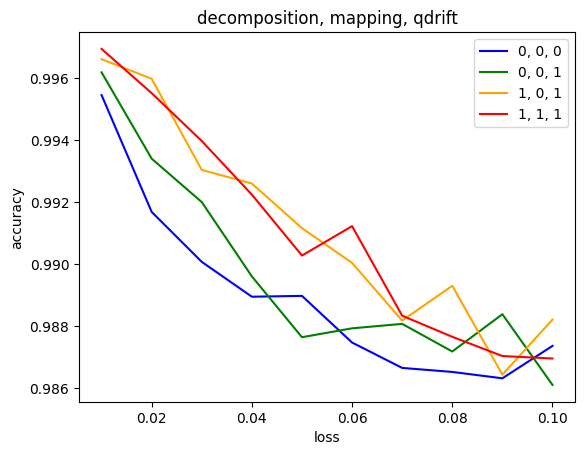

In [87]:
import matplotlib.pyplot as plt

x_axis = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# Plotting the lists
plt.plot(x_axis, acc_000, color='blue', label='0, 0, 0')
plt.plot(x_axis, acc_001, color='green', label='0, 0, 1')
plt.plot(x_axis, acc_101, color='orange', label='1, 0, 1')
plt.plot(x_axis, acc_111, color='red', label='1, 1, 1')

# Adding a legend and labels
plt.legend()
plt.xlabel('loss')
plt.ylabel('accuracy')
plt.title('decomposition, mapping, qdrift')

# Display the plot
plt.show()